# DSOML 

Subject: Implement and discuss the efficiency of 3 incremental gradient algorithm (SVRG, SAGA, MISO) and benchmark them against batch-gradient descent on a sparse logistic regression problem.

 * Importation des packages

In [1]:
from sklearn import datasets
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numba import njit
from numba import jit

 * Base simple pour tester nos algorithmes

In [2]:
np.random.seed(0)
n_samples, n_features = 100, 10
A = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = np.sign(A.dot(w) + np.random.randn(n_samples))
step_size_Ab = 1.0 / (3 * np.max((A * A).sum(1)))# ou L = np.linalg.norm(A.T.dot(A)) et : step_size = 1. / L
(n_obs_Ab,n_features_Ab)=A.shape
max_iter=100
A.shape

(100, 10)

 * Key functions

In [3]:
@njit
def loss_logistic(x,A,b):
    p = b * np.dot(A,x)
    return -np.sum(np.log(1.0 / (1.0 + np.exp(-p))))

@njit
def phi(t):
    return  1. / (1 + np.exp(-t))

@njit
def grad(x,A,b):
    z = phi(b * np.dot(A,x))
    z0 = (z - 1) * b
    grad_w = np.dot(A.T,z0) 
    return grad_w

@njit
def init_theta(n_features):
    theta=np.random.uniform(0,1,(n_features))*2-1 #afin d'avoir un theta bien random entre -1 et 1
    return theta

@njit
def accuracy(X,Y,theta):
    concordants=0
    for idx in range(len(X)):
        concordants+=np.sign(np.dot(X[idx],theta))==np.sign(Y[idx])
    #concordants=sum([np.sign(np.dot(X[idx],theta))==np.sign(Y[idx]) for idx in range(len(X))])#on remplace par la boucle pour numba
    pourcentage=float(concordants)/float(len(X))
    return pourcentage

@njit
def partial_grad(x,A,b,i):
    z = phi(b[i] * np.dot(A[i],x))
    z0 = (z - 1) * b[i]
    grad_w = A[i].T*z0
    return grad_w

In [4]:
#pour un essai avec d'autres bases:
dataframe = datasets.load_breast_cancer()
X=dataframe.data
Y=dataframe.target
Y=2*Y-np.ones(len(Y))#pour se ramener à problème avec Y = + 1 ou -1
#ne fonctionne pas avec cette base : trop simple ?
max_iter = 100
# Lipschitz constant
step_size_XY = 1.0 / (3 * np.max((X * X).sum(1)))# ou L = np.linalg.norm(A.T.dot(A)) et : step_size = 1. / L
#L = np.linalg.norm(X.T.dot(X))
#step_size = 1. / L

### Batch Gradient

In [5]:
@njit
def batch(X,Y,step_size,max_iter):
    cost_history = []
    grad_history = []
    accuracy_history = []
    (n_obs,n_features)=X.shape
    xk = init_theta(n_features)
    for i in range(max_iter):
        accuracy_history.append(accuracy(X,Y,xk))
        xk = xk - 4 * step_size * grad(xk,X,Y)
        cost_history.append(loss_logistic(xk,X,Y)) 
        grad_history.append(np.linalg.norm(grad(xk,X,Y)))
    sol=xk
    return sol,cost_history,accuracy_history,grad_history

In [6]:
sol_batchAb,cost_function_batchAb,accuracy_history_batchAb,grad_history_batchAb=batch(A,b,step_size_Ab,max_iter)

In [7]:
sol_batchXY,cost_function_batchXY,accuracy_history_batchXY,grad_history_batchXY=batch(X,Y,step_size_XY,max_iter)

### Stochastic Gradient

In [8]:
@njit
def stochastic(X,Y,step_size,max_iter):
    cost_history = []
    grad_history = []
    accuracy_history = []
    (n_samples,n_features)=X.shape
    xk = init_theta(n_features)
    for i in range(max_iter * n_samples):
        idx = np.random.randint(0, n_samples) 
        xk = xk - (step_size / np.sqrt(i+1.0)) * partial_grad(xk,X,Y, idx)
        cost_history.append(loss_logistic(xk,X,Y)) # .. insert this line to keep track of iterates ..
        grad_history.append(np.linalg.norm(grad(xk,X,Y)))
        accuracy_history.append(accuracy(X,Y,xk))
    return sol, cost_history,accuracy_history,grad_history

In [9]:
sol_stoAb,cost_function_stoAb,accuracy_history_stoAb,grad_history_stoAb=batch(A,b,step_size_Ab,max_iter)

In [10]:
sol_stoXY,cost_function_stoXY,accuracy_history_stoXY,grad_history_stoXY=batch(X,Y,step_size_XY,max_iter)

## SAGA Gradient

In [11]:
@njit
def SAGA(A, b, step_size,max_iter=100):
    (n_samples,n_features)=A.shape
    theta_k = init_theta(n_features)
    old_grad = np.zeros((n_samples, n_features))
    mean_grad = np.zeros(n_features)
    grad_history = np.ones(max_iter)
    grad_accuracy = np.ones(max_iter)
    cost_function=np.ones(max_iter)
    for i in range(n_samples * max_iter):
        idx = np.random.randint(0, n_samples)
        cur_grad = partial_grad(theta_k,A,b, idx)
        saga_update = cur_grad - old_grad[idx] + mean_grad
        mean_grad += (cur_grad - old_grad[idx]) / n_samples
        theta_k = theta_k - step_size * saga_update
        old_grad[idx] = cur_grad
        if i % n_samples == 0:
            grad_history[i // n_samples] = np.linalg.norm(grad(theta_k,A,b))
            grad_accuracy[i // n_samples] = accuracy(A,b,theta_k)
            cost_function[i // n_samples] = loss_logistic(A,b,theta_k)
    return theta_k, cost_function,grad_accuracy, grad_history

In [12]:
sol_sagaAb,cost_function_sagaAb, grad_accuracy_sagaAb, grad_history_sagaAb = SAGA(A, b,step_size_Ab,max_iter)

In [13]:
sol_sagaXY, cost_function_sagaXY,grad_accuracy_sagaXY,grad_history_sagaXY=SAGA(X,Y,step_size_XY,max_iter)

## SVRG Gradient

In [14]:
@njit
def SVRG(A, b, step_size, max_iter=100):
    (n_samples,n_features)=A.shape
    theta_k = init_theta(n_features)
    theta_tilde = theta_k.copy()
    grad_history = np.ones(max_iter)
    grad_accuracy = np.ones(max_iter)
    cost_function = np.ones(max_iter)
    for i in range(n_samples * max_iter):#parallèle cours : max_iter =T et n_samples=m ici = n mais pourrait etre < n
        if i % n_samples == 0:
            theta_tilde = theta_k.copy()
            grad_avg = grad(theta_tilde,A,b)
            grad_history[i // n_samples] = np.linalg.norm(grad(theta_k,A,b))
            grad_accuracy[i // n_samples] = accuracy(A,b,theta_k)
            cost_function[i // n_samples] = loss_logistic(A,b,theta_k)
        idx = np.random.randint(0, n_samples)
        cur_grad = partial_grad(theta_k,A,b, idx)
        prev_grad = partial_grad(theta_tilde,A,b, idx)
        svrg_update = cur_grad - prev_grad + grad_avg
        theta_k = theta_k - step_size * svrg_update
    return theta_k,cost_function,grad_accuracy, grad_history

In [15]:
#petite étude step_size

In [16]:
step_size_1=step_size_Ab
step_size_2=step_size_Ab/10.0
step_size_3=step_size_2/10.0

In [17]:
sol_svrgAb,cost_function_svrgAb, grad_accuracy_svrgAb, grad_history_svrgAb1 = SVRG(A, b,step_size_1,max_iter)
sol_svrgAb,cost_function_svrgAb, grad_accuracy_svrgAb, grad_history_svrgAb2 = SVRG(A, b,step_size_2,max_iter)
sol_svrgAb,cost_function_svrgAb, grad_accuracy_svrgAb, grad_history_svrgAb3 = SVRG(A, b,step_size_3,max_iter)

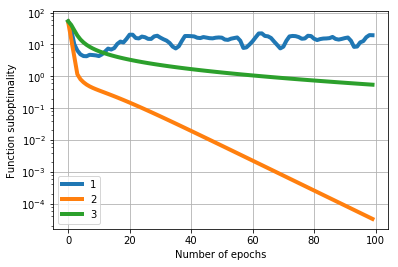

In [18]:
plt.plot(grad_history_svrgAb1, lw=4, label='1')
plt.plot(grad_history_svrgAb2, lw=4, label='2')
plt.plot(grad_history_svrgAb3, lw=4, label='3')
plt.grid()
plt.legend()
plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

In [19]:
sol_svrgXY, cost_function_svrgXY,grad_accuracy_svrgXY,grad_history_svrgXY = SVRG(X, Y,step_size_Ab,max_iter)

### MISO Gradient

In [194]:
#à faire
#@njit
def MISO(A, b, step_size,max_iter=100):
    (n_samples,n_features)=A.shape
    theta_k = init_theta(n_features)
    old_theta = np.zeros((n_samples, n_features))
    #old_theta = init_theta(n_features).reshape(1,n_features).repeat(n_samples,axis=0) 
    mean_grad = init_theta(n_features)
    grad_history = np.ones(max_iter)
    grad_accuracy = np.ones(max_iter)
    cost_function=np.ones(max_iter)
    L=1
    for i in range(n_samples * max_iter):
        idx = np.random.randint(0, n_samples)
        old_grad=partial_grad(old_theta[idx],A,b,idx)
        cur_grad = partial_grad(theta_k,A,b, idx)
        mean_grad+=(-old_grad+cur_grad)/n_samples
        theta_k=np.dot(np.ones(n_samples),old_theta)/n_samples-(step_size)*mean_grad #erreur possible ici : remplacer step_size par 1/L
        old_theta[idx]=theta_k
        if i % n_samples == 0:
            grad_history[i // n_samples] = np.linalg.norm(grad(theta_k,A,b))
            grad_accuracy[i // n_samples] = accuracy(A,b,theta_k)
            cost_function[i // n_samples] = loss_logistic(A,b,theta_k)
    return theta_k, cost_function,grad_accuracy, grad_history

In [200]:
sol_misoAb, cost_function_misoAb,grad_accuracy_misoAb,grad_history_misoAb = MISO(A, b,step_size_Ab*10,100)

In [205]:
sol_misoXY, cost_function_misoXY,grad_accuracy_misoXY,grad_history_misoXY = MISO(X, Y,step_size_XY*5,100)

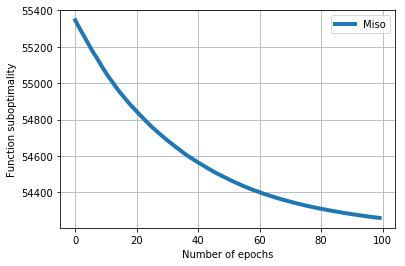

In [207]:
plt.plot(grad_history_misoXY, lw=4, label='Miso')
plt.grid()
plt.legend()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

### Résultats graphiques - comparaison de chaque

 * Base aléatoire A et b

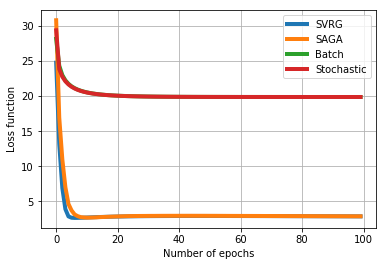

In [160]:
plt.plot(cost_function_svrgAb, lw=4, label='SVRG')
plt.plot(cost_function_sagaAb, lw=4, label='SAGA')
plt.plot(cost_function_batchAb, lw=4, label='Batch')
plt.plot(cost_function_stoAb, lw=4, label='Stochastic')
plt.grid()
plt.legend()
plt.ylabel('Loss function')
plt.xlabel('Number of epochs')
plt.show()

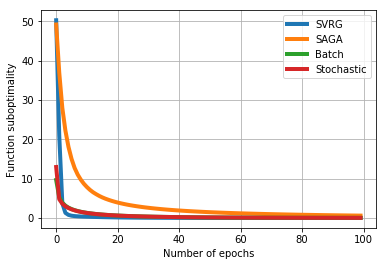

In [161]:
plt.plot(grad_history_svrgAb2, lw=4, label='SVRG')
plt.plot(grad_history_sagaAb, lw=4, label='SAGA')
plt.plot(grad_history_batchAb, lw=4, label='Batch')
plt.plot(grad_history_stoAb, lw=4, label='Stochastic')
plt.grid()
plt.legend()
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

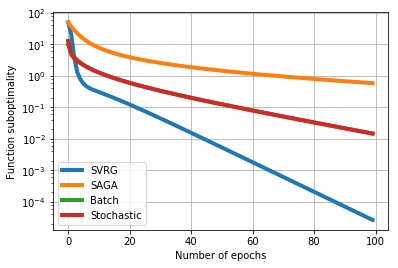

In [162]:
plt.plot(grad_history_svrgAb2, lw=4, label='SVRG')
plt.plot(grad_history_sagaAb, lw=4, label='SAGA')
plt.plot(grad_history_batchAb, lw=4, label='Batch')
plt.plot(grad_history_stoAb, lw=4, label='Stochastic')
plt.grid()
plt.legend()
plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

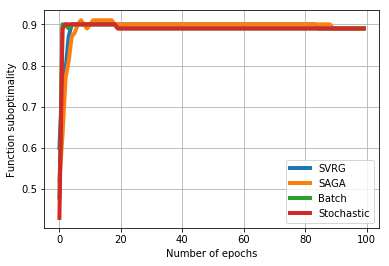

In [163]:
plt.plot(grad_accuracy_svrgAb, lw=4, label='SVRG')
plt.plot(grad_accuracy_sagaAb, lw=4, label='SAGA')
plt.plot(accuracy_history_batchAb, lw=4, label='Batch')
plt.plot(accuracy_history_stoAb, lw=4, label='Stochastic')
plt.grid()
plt.legend()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

 * Base sur cancer du sein - 569 individus - 30 variables

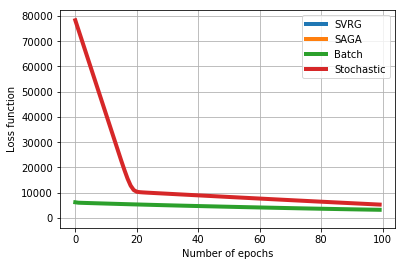

In [164]:
plt.plot(cost_function_svrgXY, lw=4, label='SVRG')
plt.plot(cost_function_sagaXY, lw=4, label='SAGA')
plt.plot(cost_function_batchXY, lw=4, label='Batch')
plt.plot(cost_function_stoXY, lw=4, label='Stochastic')
plt.grid()
plt.legend()
plt.ylabel('Loss function')
plt.xlabel('Number of epochs')
plt.show()

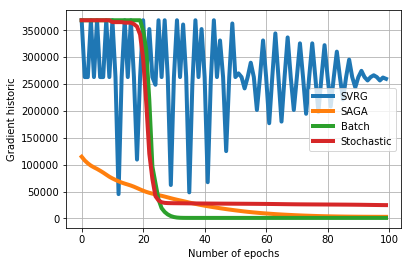

In [202]:
plt.plot(grad_history_svrgXY, lw=4, label='SVRG')
plt.plot(grad_history_jit_sagaXY, lw=4, label='SAGA')
plt.plot(grad_history_batchXY, lw=4, label='Batch')
plt.plot(grad_history_stoXY, lw=4, label='Stochastic')
plt.grid()
plt.legend()
plt.ylabel('Gradient historic')
plt.xlabel('Number of epochs')
plt.show()

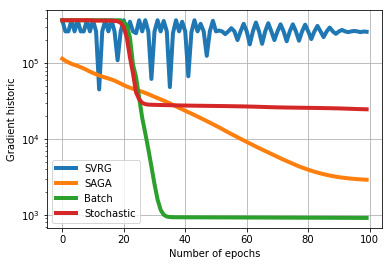

In [201]:
plt.plot(grad_history_svrgXY, lw=4, label='SVRG')
plt.plot(grad_history_jit_sagaXY, lw=4, label='SAGA')
plt.plot(grad_history_batchXY, lw=4, label='Batch')
plt.plot(grad_history_stoXY, lw=4, label='Stochastic')
plt.grid()
plt.legend()
plt.yscale('log')
plt.ylabel('Gradient historic')
plt.xlabel('Number of epochs')
plt.show()

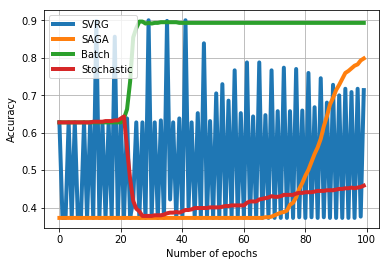

In [200]:
plt.plot(grad_accuracy_svrgXY, lw=4, label='SVRG')
plt.plot(grad_accuracy_sagaXY, lw=4, label='SAGA')
plt.plot(accuracy_history_batchXY, lw=4, label='Batch')
plt.plot(accuracy_history_stoXY, lw=4, label='Stochastic')
plt.grid()
plt.legend()
#plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.show()

In [107]:
#essai sur base DSG2K17

In [83]:
import multiprocessing
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

import datetime
import time
import pickle
import math

In [84]:
data_path = "C:/Users/brian/Documents/DSG2K17/0. Data/"
train_path = data_path + "train.csv"
test_path = data_path + "test.csv"

In [85]:
start = time.time()
df = pd.read_csv(train_path)
print("train file loaded in " + str(round(time.time() - start, 2)) + "s")
print("train shape : " + str(df.shape))

df_submit = pd.read_csv(test_path)
print("test shape : " + str(df_submit.shape))

train file loaded in 10.29s
train shape : (7558834, 15)
test shape : (19918, 15)


In [86]:
def split_train_test(full_dataframe):
    # ajout des index dans les colonnes
    full_dataframe["idx"] = full_dataframe.index
    # on récupère toutes les écoutes les plus récentes ppur chaque user
    sorted_df = df.sort_values('ts_listen', ascending=False).groupby('user_id', as_index=False).first()
    # on enlève celles pour lequelles le user n'a écouté qu'une musique
    user_group = full_dataframe.groupby("user_id")["is_listened"].count()
    users_une_ecoute = user_group[user_group == 1]
    temp_test_df = sorted_df[~sorted_df["user_id"].isin(users_une_ecoute.index)]

    # on balance dans 2 dataframes les ligne suivant si elles sont dans temp_test_df ou non
    test_df = full_dataframe.loc[temp_test_df['idx']].reset_index(drop=True)
    test_df["sample_id"] = test_df.index
    train_df = full_dataframe[~full_dataframe["idx"].isin(temp_test_df['idx'])].reset_index(drop=True)

    return train_df, test_df

In [87]:
start = time.time()
train_df,test_df = split_train_test(df)
end = time.time()
print("Done in " + str(end-start) + 's')

Done in 9.10099983215s


In [88]:
def evaluate_submission(loc_test_df,submission):
    """compute the AUC for our own test set"""
    # on joint le test_set et la submission sur la clé "sample_id"
    joined = loc_test_df[["sample_id","is_listened"]].rename(columns={"sample_id":"sample_id",'is_listened':"y_true"}).merge(submission, on="sample_id")
    # on extrait les champs true_value et score et on calcule le score AUC
    return roc_auc_score(list(joined["y_true"]),list(joined["is_listened"]))

In [89]:
C=train_df[['media_id', 'album_id', 'release_date', 'media_duration', 'listen_type', 'user_id', 'artist_id', 'genre_id','user_age','user_gender']]
D=train_df["is_listened"]

In [90]:
C=C.values
D=D.values
indice = (len(C)-1)//100
#cross validation
X_train = C[:indice, :]
Y_train = D[:indice]
X_test = C[indice:, :]
Y_test = D[indice:]

In [91]:
len(X_train)

75391

In [93]:
step_size_deezer = 1.0 / (3 * np.max((X_train * X_train).sum(1)))# ou L = np.linalg.norm(A.T.dot(A)) et : step_size = 1. / L

In [94]:
sol_svrgdeezer, grad_accuracy_svrgdeezer, grad_history_svrgdeezer = SVRG(X_train,Y_train,step_size_deezer,max_iter=100)

KeyboardInterrupt: 

In [ ]:
#sol_sagadeezer, grad_accuracy_sagadeeezer, grad_history_sagadeezer = SAGA_jit(X_train,Y_train,step_size_deezer,max_iter=100)
#accuracy_history_batchdeezer,cost_history_batchdeezer,grad_history_batchdeezer=batch(X_train,Y_train,step_size_deezer,max_iter=100)


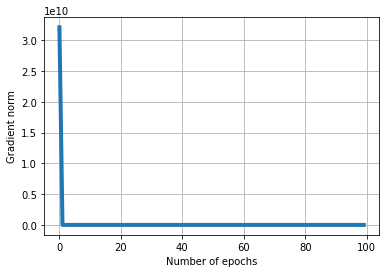

In [95]:
plt.plot(grad_history_svrgAb, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Gradient norm')
plt.xlabel('Number of epochs')
plt.show()

In [108]:
np.dot(sol_svrgAb,C[10])

4.2244301591796212e+19

In [98]:
train_df.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,idx
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1,2
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0,3
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,4


In [ ]:
#essai avec le titanic

In [70]:
df = pd.read_csv('C:/Users/brian/Documents/ENSAE/3A/Semestre 2/DSOML/Projet/Dataset/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [71]:
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)
age_mean = df['Age'].mean()
df['Age'] = df['Age'].fillna(age_mean)
from scipy.stats import mode
mode_embarked = mode(df['Embarked'])[0][0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)
df['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)
df = df.drop(['Sex', 'Embarked'], axis=1)
cols = df.columns.tolist()
cols = [cols[1]] + cols[0:1] + cols[2:]
df = df[cols]

In [72]:
train_data = df.values

In [73]:
step_size_tita = 1.0 / (3 * np.max((train_data * train_data).sum(1)))# ou L = np.linalg.norm(A.T.dot(A)) et : step_size = 1. / L

In [77]:
accuracy_history_batchtita,cost_history_batchtita,grad_history_batchtita=batch(train_data[0:,2:],train_data[0:,0],step_size_tita,100)
sol_svrgtita, grad_accuracy_svrgtita, grad_history_svrgtita = SVRG(train_data[0:,2:],train_data[0:,0],step_size_tita,max_iter=100)
sol_sagatita, grad_accuracy_sagatita, grad_history_sagatita = SAGA_jit(train_data[0:,2:],train_data[0:,0],step_size_tita,max_iter=100)

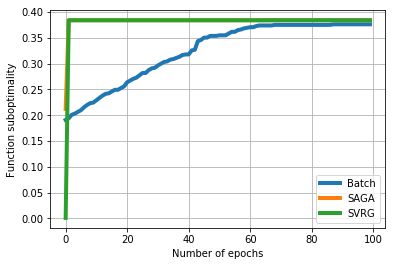

In [81]:
plt.plot(accuracy_history_batchtita, lw=4, label='Batch')
plt.plot(grad_accuracy_sagatita, lw=4, label='SAGA')
plt.plot(grad_accuracy_svrgtita, lw=4, label='SVRG')
plt.grid()
plt.legend()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

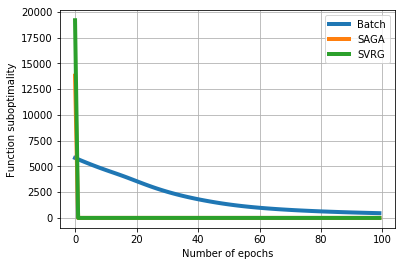

In [82]:
plt.plot(grad_history_batchtita, lw=4, label='Batch')
plt.plot(grad_history_sagatita, lw=4, label='SAGA')
plt.plot(grad_history_svrgtita, lw=4, label='SVRG')
plt.grid()
plt.legend()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()